In [ ]:
import os, random, math, time
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device_count = torch.cuda.device_count()
assert device_count >= 1, "GPU not found. Set accelerator to GPU in Kaggle."
print("CUDA devices:", device_count, [torch.cuda.get_device_name(i) for i in range(device_count)])

ROLL_NUMBER = 22051925
seed = ROLL_NUMBER % 100  # last two digits = 25

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

set_seed(seed)

hidden_dim = 128 + (seed % 5) * 32      # 128 + 0 = 128
num_heads  = 4   + (seed % 3)           # 4 + 1 = 5
patch_size = 8   + (seed % 4) * 2       # 8 + 2 = 10
epochs     = 10  + (seed % 5)           # 10 + 0 = 10

DATASET = "Fashion-MNIST"
NUM_CLASSES = 10
IMG_SIZE_ORIG = 28
IMG_SIZE = 30

BATCH_SIZE = 256
LR = 3e-4
WEIGHT_DECAY = 0.05
ACCUM_STEPS = 1
AMP = True

print(f"Params → seed={seed}, hidden_dim={hidden_dim}, num_heads={num_heads}, patch_size={patch_size}, epochs={epochs}")
print(f"Dataset: {DATASET}, image size: {IMG_SIZE}x{IMG_SIZE} (padded from 28x28), patches per side: {IMG_SIZE//patch_size}")


CUDA devices: 1 ['Tesla T4']
Params → seed=25, hidden_dim=128, num_heads=5, patch_size=10, epochs=10
Dataset: Fashion-MNIST, image size: 30x30 (padded from 28x28), patches per side: 3


In [ ]:
train_tfms = transforms.Compose([
    transforms.Pad(padding=1, fill=0),           
    transforms.RandomCrop(IMG_SIZE, padding=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),                       
    transforms.Normalize((0.5,), (0.5,)),        
])

test_tfms = transforms.Compose([
    transforms.Pad(padding=1, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

root = "/kaggle/working/data"
os.makedirs(root, exist_ok=True)

train_ds = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=train_tfms)
test_ds  = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

classes = train_ds.classes
classes


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.71MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 178kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.18MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.1MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class PatchEmbed(nn.Module):
    """Split image into patches and linearly embed them."""
    def __init__(self, img_size=30, patch_size=10, in_chans=1, embed_dim=128):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches_side = img_size // patch_size
        self.num_patches = self.num_patches_side ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)              
        x = x.flatten(2)              
        x = x.transpose(1, 2)         
        return x

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, p=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class MultiHeadSelfAttention(nn.Module):
    """Manual MSA with QKV projections; returns attn weights for viz."""
    def __init__(self, dim, num_heads, attn_dropout=0.0, proj_dropout=0.0):
        super().__init__()
        assert dim % num_heads == 0, "embed dim must be divisible by heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_dropout)

        self.last_attn = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.view(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        self.last_attn = attn.detach()

        out = attn @ v 
        out = out.transpose(1, 2).contiguous().view(B, N, C) 
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, attn_dropout=0.0, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads, attn_dropout, drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), p=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [ ]:
class MiniViT(nn.Module):
    def __init__(self, img_size=30, patch_size=10, in_chans=1, num_classes=10,
                 embed_dim=128, depth=6, num_heads=5, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(drop)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, drop, drop) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x, return_attn=False):
        B = x.size(0)
        x = self.patch_embed(x)  
        cls = self.cls_token.expand(B, -1, -1)  
        x = torch.cat([cls, x], dim=1)          
        x = x + self.pos_embed
        x = self.pos_drop(x)

        attn_maps = []
        for blk in self.blocks:
            x = blk(x)
            attn_maps.append(blk.attn.last_attn)

        x = self.norm(x)
        cls_out = x[:, 0]
        logits = self.head(cls_out)
        if return_attn:
            return logits, attn_maps
        return logits


In [ ]:
from tqdm.auto import tqdm

def top1_accuracy(logits, targets):
    pred = logits.argmax(dim=1)
    return (pred == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, device="cuda"):
    model.eval()
    all_logits, all_targets = [], []
    for images, targets in loader:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        logits = model(images)
        all_logits.append(logits.cpu())
        all_targets.append(targets.cpu())
    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)
    acc = (all_logits.argmax(1) == all_targets).float().mean().item()
    return acc, all_logits.numpy(), all_targets.numpy()

def train_model(model, train_loader, test_loader, epochs=10, lr=3e-4, wd=0.05, amp=True, device="cuda"):
    model = model.to(device)
    if device_count > 1:
        model = nn.DataParallel(model)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.cuda.amp.GradScaler(enabled=amp)
    lr_schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    train_acc_hist, test_acc_hist = [], []
    best_acc, best_state = 0.0, None

    for epoch in range(1, epochs + 1):
        model.train()
        total, correct = 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=amp):
                logits = model(images)
                loss = F.cross_entropy(logits, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            pred = logits.argmax(1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)
            pbar.set_postfix(loss=float(loss.item()), train_acc=correct/total)

        lr_schedule.step()

        train_acc = correct / total
        test_acc, _, _ = evaluate(model, test_loader, device=device)
        train_acc_hist.append(train_acc)
        test_acc_hist.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            if isinstance(model, nn.DataParallel):
                best_state = model.module.state_dict()
            else:
                best_state = model.state_dict()

        print(f"[Epoch {epoch}] train_acc={train_acc:.4f} | test_acc={test_acc:.4f} | best={best_acc:.4f}")

    if best_state is not None:
        if isinstance(model, nn.DataParallel):
            model.module.load_state_dict(best_state)
        else:
            model.load_state_dict(best_state)

    return model, train_acc_hist, test_acc_hist


In [ ]:
embed_dim = 160

vit = MiniViT(
    img_size=IMG_SIZE,
    patch_size=patch_size,
    in_chans=1,
    num_classes=NUM_CLASSES,
    embed_dim=embed_dim,
    depth=6,
    num_heads=num_heads,
    mlp_ratio=4.0,
    drop=0.1
)

vit, train_hist, test_hist = train_model(
    vit, train_loader, test_loader,
    epochs=epochs, lr=LR, wd=WEIGHT_DECAY, amp=AMP, device="cuda"
)

os.makedirs("/kaggle/working/checkpoints", exist_ok=True)
torch.save(vit.state_dict(), "/kaggle/working/checkpoints/minivit_fmnist_seed25.pth")
print("Saved checkpoint.")

/tmp/ipython-input-467187462.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10:   0%|          | 0/234 [00:00<?, ?it/s]

/tmp/ipython-input-467187462.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


[Epoch 1] train_acc=0.7177 | test_acc=0.8054 | best=0.8054


Epoch 2/10:   0%|          | 0/234 [00:00<?, ?it/s]

[Epoch 2] train_acc=0.8229 | test_acc=0.8438 | best=0.8438


Epoch 3/10:   0%|          | 0/234 [00:00<?, ?it/s]

[Epoch 3] train_acc=0.8460 | test_acc=0.8520 | best=0.8520


Epoch 4/10:   0%|          | 0/234 [00:00<?, ?it/s]

[Epoch 4] train_acc=0.8589 | test_acc=0.8623 | best=0.8623


Epoch 5/10:   0%|          | 0/234 [00:00<?, ?it/s]

[Epoch 5] train_acc=0.8680 | test_acc=0.8670 | best=0.8670


Epoch 6/10:   0%|          | 0/234 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>^^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():
^ ^ ^^  ^  

[Epoch 6] train_acc=0.8746 | test_acc=0.8735 | best=0.8735


Epoch 7/10:   0%|          | 0/234 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^Exception ignored in: self._shutdown_workers()

Exception ignored in:   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540><function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader

[Epoch 7] train_acc=0.8836 | test_acc=0.8778 | best=0.8778


Epoch 8/10:   0%|          | 0/234 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
Exception ignored in: if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>  self._shutdown_workers()

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
 i

[Epoch 8] train_acc=0.8862 | test_acc=0.8814 | best=0.8814


Epoch 9/10:   0%|          | 0/234 [00:00<?, ?it/s]

[Epoch 9] train_acc=0.8919 | test_acc=0.8860 | best=0.8860


Epoch 10/10:   0%|          | 0/234 [00:00<?, ?it/s]

[Epoch 10] train_acc=0.8940 | test_acc=0.8870 | best=0.8870
Saved checkpoint.


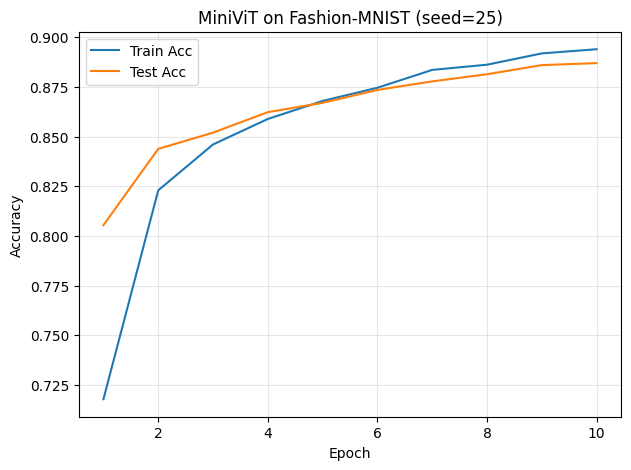

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(1, len(train_hist)+1), train_hist, label="Train Acc")
plt.plot(range(1, len(test_hist)+1),  test_hist,  label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MiniViT on Fashion-MNIST (seed=25)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
     self._shutdown_workers()   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

Exception ignored in:      <function _MultiProcessingDataLoaderIter.__del__ at 0x7ea92ddf0540>
if w.is_alive(): 
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1

Final Test Accuracy: 0.8870


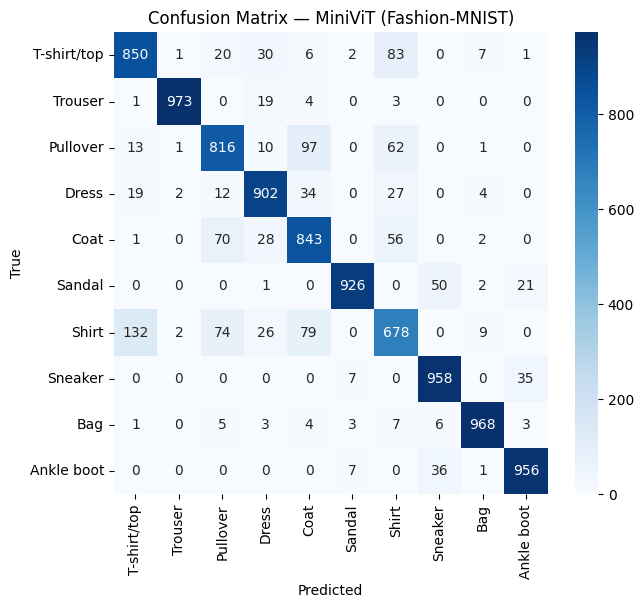


Classification Report:

              precision    recall  f1-score   support

 T-shirt/top     0.8358    0.8500    0.8428      1000
     Trouser     0.9939    0.9730    0.9833      1000
    Pullover     0.8185    0.8160    0.8172      1000
       Dress     0.8852    0.9020    0.8935      1000
        Coat     0.7901    0.8430    0.8157      1000
      Sandal     0.9799    0.9260    0.9522      1000
       Shirt     0.7402    0.6780    0.7077      1000
     Sneaker     0.9124    0.9580    0.9346      1000
         Bag     0.9738    0.9680    0.9709      1000
  Ankle boot     0.9409    0.9560    0.9484      1000

    accuracy                         0.8870     10000
   macro avg     0.8871    0.8870    0.8866     10000
weighted avg     0.8871    0.8870    0.8866     10000



In [ ]:
acc, logits_np, targets_np = evaluate(vit, test_loader, device="cuda")
preds_np = logits_np.argmax(1)
print(f"Final Test Accuracy: {acc:.4f}")

cm = confusion_matrix(targets_np, preds_np, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion Matrix — MiniViT (Fashion-MNIST)")
plt.show()

print("\nClassification Report:\n")
print(classification_report(targets_np, preds_np, target_names=classes, digits=4))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


True: Ankle boot, Pred: Ankle boot


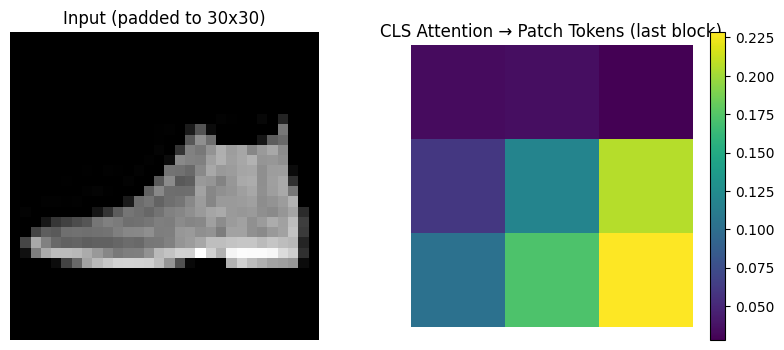

In [ ]:
def get_one(loader):
    for x, y in loader:
        return x[:1], y[:1]

def forward_with_attn(model, x):
    if isinstance(model, nn.DataParallel):
        model = model.module
    model.eval()
    with torch.no_grad():
        logits, attn_maps = model(x.cuda(), return_attn=True)
    return logits, attn_maps

x, y = get_one(test_loader)
x_cuda = x.cuda(non_blocking=True)
logits, attn_maps = forward_with_attn(vit, x_cuda)
pred = logits.argmax(1).item()
print(f"True: {classes[y.item()]}, Pred: {classes[pred]}")

last_attn = attn_maps[-1].mean(1).squeeze(0).cpu().numpy()
cls_to_tokens = last_attn[0]  
cls_to_patches = cls_to_tokens[1:]
num_patches_side = IMG_SIZE // patch_size
attn_grid = cls_to_patches.reshape(num_patches_side, num_patches_side)

img_np = x[0,0].numpy()
img_disp = (img_np * 0.5 + 0.5)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_disp, cmap="gray")
plt.title(f"Input (padded to {IMG_SIZE}x{IMG_SIZE})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(attn_grid, interpolation="nearest")
plt.title("CLS Attention → Patch Tokens (last block)")
plt.colorbar()
plt.axis("off")
plt.show()

[CNN ep1] train_acc=0.7636, test_acc=0.8365
[CNN ep2] train_acc=0.8590, test_acc=0.8663
[CNN ep3] train_acc=0.8784, test_acc=0.8789


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


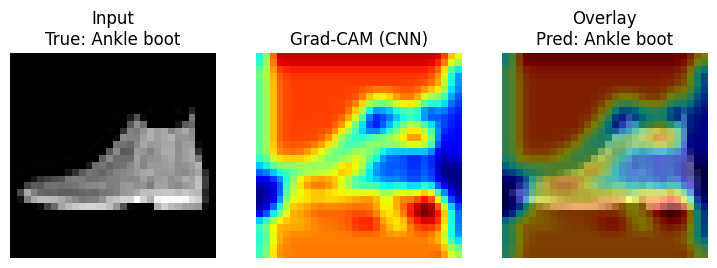

In [ ]:
class CNNBaseline(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 30->15
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(3),  # 15->5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 128), nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

def train_quick(model, train_loader, test_loader, epochs=5, lr=1e-3, device="cuda"):
    model = model.to(device)
    if device_count > 1:
        model = nn.DataParallel(model)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        model.train()
        correct = total = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()
            pred = logits.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
        test_acc, _, _ = evaluate(model, test_loader, device=device)
        print(f"[CNN ep{ep}] train_acc={correct/total:.4f}, test_acc={test_acc:.4f}")
    return model

cnn = CNNBaseline(NUM_CLASSES)
cnn = train_quick(cnn, train_loader, test_loader, epochs=3)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        def fwd_hook(m, i, o): self.activations = o.detach()
        def bwd_hook(m, gi, go): self.gradients = go[0].detach()
        self.h1 = target_layer.register_forward_hook(fwd_hook)
        self.h2 = target_layer.register_backward_hook(bwd_hook)
    def __del__(self):
        self.h1.remove(); self.h2.remove()
    def __call__(self, x, class_idx=None):
        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(1)
        loss = logits[0, class_idx] if logits.ndim == 2 else logits[0, class_idx.item()]
        self.model.zero_grad(set_to_none=True)
        loss.backward(retain_graph=True)
        weights = self.gradients.mean(dim=(2,3), keepdim=True) # (B, C, 1, 1)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # (B,1,H,W)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return logits.detach(), cam.detach()

target_layer = cnn.module.features[3] if isinstance(cnn, nn.DataParallel) else cnn.features[3]
gradcam = GradCAM(cnn, target_layer)

x1, y1 = next(iter(test_loader))
x1, y1 = x1[:1].cuda(), y1[:1].cuda()
logits, cam = gradcam(x1)
pred = logits.argmax(1).item()

plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
plt.imshow((x1[0,0].cpu().numpy()*0.5+0.5), cmap='gray')
plt.title(f"Input\nTrue: {classes[y1.item()]}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cam[0,0].cpu().numpy(), cmap='jet')
plt.title("Grad-CAM (CNN)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow((x1[0,0].cpu().numpy()*0.5+0.5), cmap='gray')
plt.imshow(cam[0,0].cpu().numpy(), cmap='jet', alpha=0.5)
plt.title(f"Overlay\nPred: {classes[pred]}")
plt.axis("off")
plt.show()

In [ ]:
print("=== Roll-Param Summary ===")
print(f"Roll number        : {ROLL_NUMBER}")
print(f"seed (last 2 digits): {seed}")
print(f"hidden_dim         : {hidden_dim}")
print(f"num_heads          : {num_heads}")
print(f"patch_size         : {patch_size}")
print(f"epochs             : {epochs}")
print(f"image size (padded): {IMG_SIZE}x{IMG_SIZE} (from 28x28)")
print(f"Dataset            : {DATASET}")
print("\nRepro tips:")
print("- Keep same seed, hyperparams, and transforms.")
print("- Use the saved checkpoint for exact inference results.")
print("- Hardware: T4 x2 (DataParallel). AMP=True.")

=== Roll-Param Summary ===
Roll number        : 22051925
seed (last 2 digits): 25
hidden_dim         : 128
num_heads          : 5
patch_size         : 10
epochs             : 10
image size (padded): 30x30 (from 28x28)
Dataset            : Fashion-MNIST

Repro tips:
- Keep same seed, hyperparams, and transforms.
- Use the saved checkpoint for exact inference results.
- Hardware: T4 x2 (DataParallel). AMP=True.
